<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool

import warnings

In [2]:
RANDOM_STATE = 12345

In [3]:
warnings.filterwarnings("ignore")

## Подготовка

In [4]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])
df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Данные соответствуют типам и не пропусков нет, сделаем дату индексом

In [6]:
df = df.set_index('datetime')
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, возрастает отсортированны ли данные по возрастанию

In [7]:
df.index.is_monotonic

True

Нам необходимо предсказать количесво заказов на следующий час, сделаем ресемплирование на час

In [8]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
df.shape

(4416, 1)

## Анализ

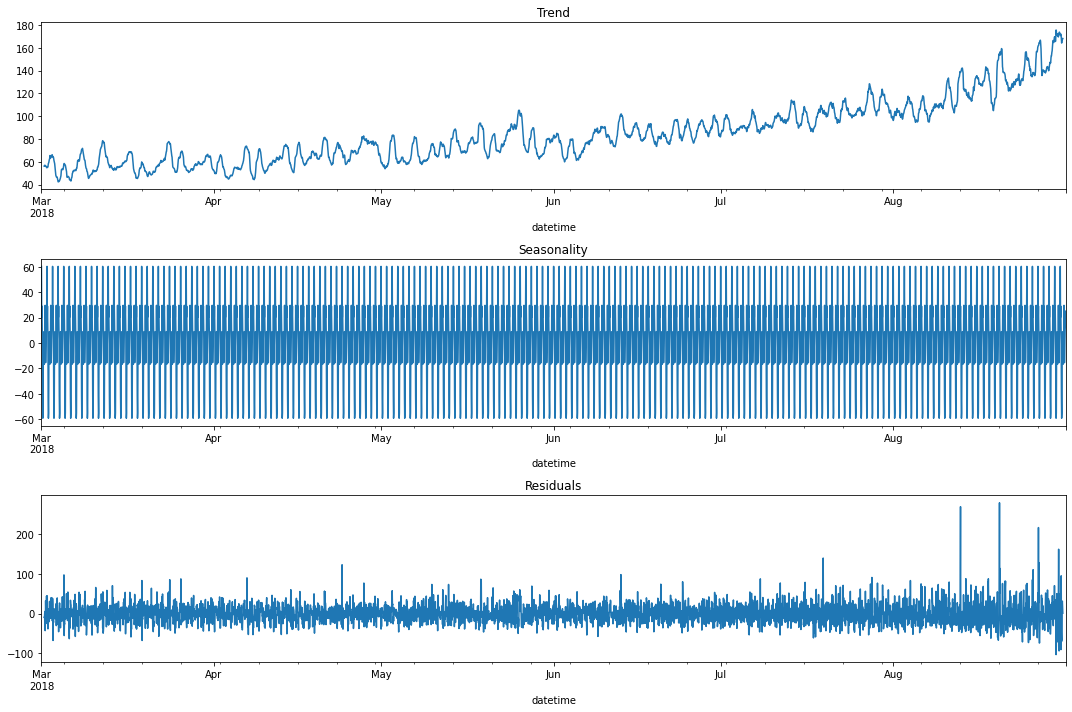

In [10]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

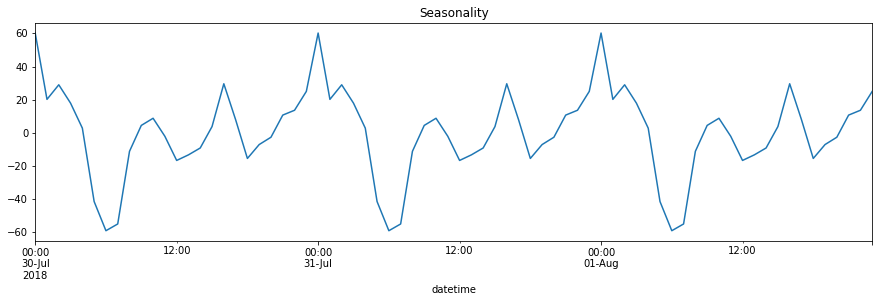

In [11]:
plt.figure(figsize=(15, 4));
decomposed.seasonal['2018-07-30':'2018-08-01'].plot(ax=plt.gca());
plt.title('Seasonality');

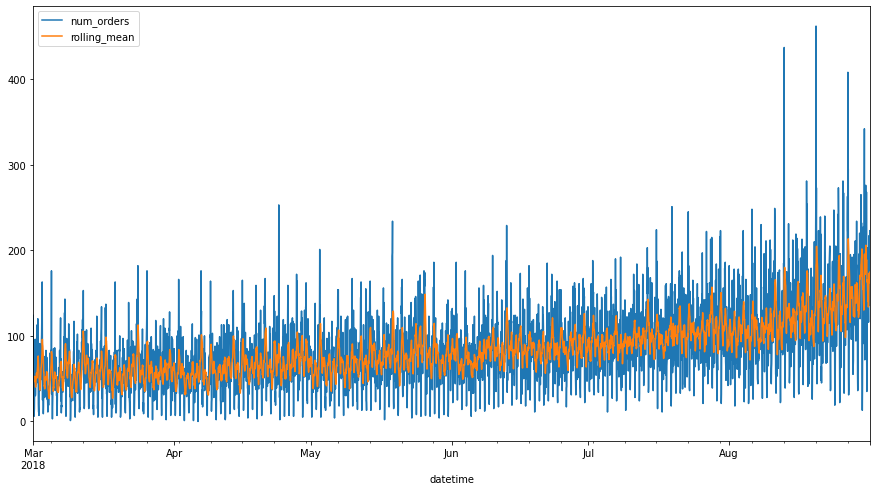

In [12]:
df['rolling_mean'] = df.rolling(10).mean()
df.plot(figsize=(15, 8));

Из декомпозиции можно отметить, что тренд указывает на увеличение заказов. Сезоность указывает на высокий спрос на такси в ночное время, потому что в это время не работает общественный транспорт.

Можно сказать, что временной ряд нестационарный

## Обучение

### Подготовка признаков

In [13]:
def make_features(df, max_lag, rolling_mean_size):
    df_new = df.copy()
    df_new['year'] = df_new.index.year
    df_new['month'] = df_new.index.month
    df_new['day'] = df_new.index.day
    df_new['dayofweek'] = df_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_new['lag_{}'.format(lag)] = df_new['num_orders'].shift(lag)

    df_new['rolling_mean'] = df_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df_new

In [14]:
df_new = make_features(df, 500, 300)
df.shape

(4416, 2)

In [15]:
df_new.head()

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_491,lag_492,lag_493,lag_494,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,2018,3,1,3,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2018,3,1,3,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,2018,3,1,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,2018,3,1,3,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_new = df_new.dropna()
df_new.shape

(3916, 506)

In [17]:
df_new.head()

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_491,lag_492,lag_493,lag_494,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-21 20:00:00,60,56.580000,2018,3,21,2,41.0,95.0,61.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-21 21:00:00,65,56.660000,2018,3,21,2,60.0,41.0,95.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-21 22:00:00,73,56.733333,2018,3,21,2,65.0,60.0,41.0,95.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-21 23:00:00,53,56.833333,2018,3,21,2,73.0,65.0,60.0,41.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-22 00:00:00,139,56.846667,2018,3,22,3,53.0,73.0,65.0,60.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


In [18]:
features = df_new.drop('num_orders', axis = 1)
target = df_new['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1)

### LinearRegression

In [19]:
model_lr = LinearRegression()

tscv = TimeSeriesSplit(n_splits=5)

lr_scores = cross_val_score(model_lr, 
                            features_train, 
                            target_train, 
                            cv=tscv, 
                            scoring='neg_root_mean_squared_error',
                            verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END .............................. score: (test=-83.915) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END .............................. score: (test=-25.612) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END .............................. score: (test=-23.831) total time=   1.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s


[CV] END .............................. score: (test=-24.898) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.1s remaining:    0.0s


[CV] END .............................. score: (test=-29.223) total time=   1.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.6s finished


In [20]:
print('Метрика RMSE для LinearRegression:', abs(lr_scores.mean()))

Метрика RMSE для LinearRegression: 37.49572515618034


### CatBoost

In [21]:
train_pool = Pool(data=features_train,
                  label=target_train,
                 )

catboost = CatBoostRegressor(loss_function='RMSE', verbose=20, random_state=RANDOM_STATE)

parameters_cat = {'learning_rate':np.arange(0.1,1,0.2),
                  'iterations': range(20, 60, 20)}

catboost_grid = catboost.grid_search(parameters_cat, train_pool,
            cv=tscv,
            verbose=True,
            plot=False)

0:	learn: 75.8630624	test: 108.2707216	best: 108.2707216 (0)	total: 320ms	remaining: 6.07s
19:	learn: 24.0417021	test: 43.8968207	best: 43.8968207 (19)	total: 2.65s	remaining: 0us

bestTest = 43.8968207
bestIteration = 19

0:	loss: 43.8968207	best: 43.8968207 (0)	total: 3.53s	remaining: 31.7s
0:	learn: 61.7570940	test: 91.1748576	best: 91.1748576 (0)	total: 202ms	remaining: 3.84s
19:	learn: 18.8282497	test: 31.9117143	best: 31.8846400 (18)	total: 2.48s	remaining: 0us

bestTest = 31.88463999
bestIteration = 18

1:	loss: 31.8846400	best: 31.8846400 (1)	total: 6.01s	remaining: 24s
0:	learn: 48.3816885	test: 74.7045150	best: 74.7045150 (0)	total: 177ms	remaining: 3.36s
19:	learn: 17.4774851	test: 31.6353954	best: 31.6353954 (19)	total: 2.63s	remaining: 0us

bestTest = 31.63539535
bestIteration = 19

2:	loss: 31.6353954	best: 31.6353954 (2)	total: 8.65s	remaining: 20.2s
0:	learn: 36.5479323	test: 59.3824757	best: 59.3824757 (0)	total: 236ms	remaining: 4.49s
19:	learn: 16.5503778	test: 31.48

In [22]:
catboost_rmse = min(catboost_grid['cv_results']['test-RMSE-mean'])
print('RMSE catboost:', catboost_rmse)

RMSE catboost: 25.346302958251822


Среди двух моделей получили лучшую, это CatBoost занчение RMSE получилось чуть лучше чем у линейной регресии

## Тестирование

In [23]:
catboost_grid['params']

{'iterations': 40, 'learning_rate': 0.5000000000000001}

In [24]:
test_pool = Pool(data=features_test,
                  label=target_test,
                 )

In [25]:
cb_model = CatBoostRegressor(loss_function='RMSE', **catboost_grid['params'], verbose=10, random_state=RANDOM_STATE)
cb_model.fit(train_pool, eval_set=test_pool)

0:	learn: 29.4302336	test: 66.8323220	best: 66.8323220 (0)	total: 297ms	remaining: 11.6s
10:	learn: 20.2393660	test: 41.5827989	best: 41.5827989 (10)	total: 2.19s	remaining: 5.77s
20:	learn: 18.7413322	test: 40.8261272	best: 40.8261272 (20)	total: 3.69s	remaining: 3.34s
30:	learn: 17.0727120	test: 39.7554641	best: 39.7484915 (28)	total: 5.5s	remaining: 1.6s
39:	learn: 15.5771424	test: 39.7547052	best: 39.3572076 (35)	total: 7.21s	remaining: 0us

bestTest = 39.35720763
bestIteration = 35

Shrink model to first 36 iterations.


In [26]:
print('RMSE CatBoost:', cb_model.best_score_['validation']['RMSE'])

RMSE CatBoost: 39.35720763450165


In [27]:
predictions = cb_model.predict(features_test)

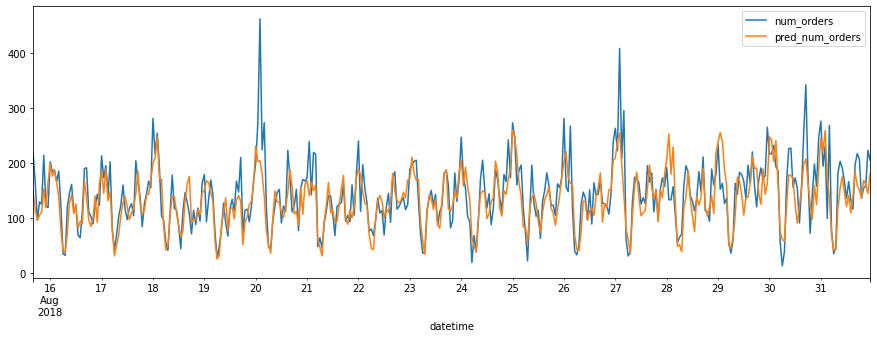

In [28]:
prediction_frame = target_test.to_frame()
prediction_frame['pred_num_orders'] = predictions
prediction_frame.plot(figsize=(15, 5));

Метрика получилась меньше 48, как и требовалось, осталось проверить модель на адекватность, сравнив с константной моделью

In [29]:
dummy_model = DummyRegressor()
dummy_model.fit(features_train, target_train)
dummy_predictions = dummy_model.predict(features_test)
mse = mean_squared_error(target_test, dummy_predictions)
print('Метрика RMSE для dummy: ', mse ** 0.5)

Метрика RMSE для dummy:  84.82973039380086


Метрика у константной модели почти в два раза хуже, значит наша модель показывает хороший результат